# **<center><mark> Basic Correlation and Cointegration Tests </mark> </center>**


### Importing Python Libraries

In [34]:
%matplotlib inline
# necessary 
import yfinance as yf
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# graphing models
import matplotlib.pyplot as plt
import seaborn as sns

# statistical models
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson

# Training and Testing model
from sklearn.model_selection import train_test_split

# time measurement
import time

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

In [35]:
start = time.time()

### <b>All Functions </b>

#### Correlation Matrix plot

In [36]:
# Compute the correlation matrix
def correlation_matrix(dataset):
        
    corr = dataset.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 5))
    plt.title(dataset.name)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
    plt.show()

#### ADF pair test

In [37]:
# For adfresult, index 0 carries t-statistic, index 1 contatins p-value and index 4 stores the dictionary of critical values for different confidence levels
def adfpair_test(dataset,list):
    for i in range(0,len(list)):
        result = sm.OLS(dataset[list[i][0]],dataset[list[i][1]]).fit()
        adfresult = ts.adfuller(result.resid)
        # display(adfresult)
        if adfresult[0] < adfresult[4]['10%'] and adfresult[1] <= 0.1:
            # beta is the cointegration coefficient for the OLS model later
            beta = result.rsquared
            print(list[i][0], " and " ,list[i][1], " are cointegrated. p - value is:",adfresult[1])
            print(result.summary())
            plt.title('Residuals')
            sns.lineplot(result.resid)
        else: 
            print(list[i][0], " and ", list[i][1], " are NOT cointegrated. p - value is:",adfresult[1])

    print("This is for 90% confidence interval")

#### Engel Granger Test

In [38]:
def EG_test(dataset):
    for i in range(0,10):
        score, pvalue, _ = coint(dataset[list[i][0]], dataset[list[i][1]], trend='c', autolag='AIC')
        
        # IF t-statistic is positive, then ADF test is not appropriate
        if pvalue < 0.05:
            print(list[i][0], " and " ,list[i][1], " are cointegrated. p - value is:",pvalue, "t-statistics is:",score)
        else: 
            print(list[i][0], " and ", list[i][1], " are NOT cointegrated. p - value is:",pvalue, "t-statistics is:",score)

#### Autocorrelation Test

In [39]:
def autocorr(stock1,stock2,dataset):
    try: 
        dataset1 = dataset[stock1]
        dataset2 = dataset[stock2]
        model = ols('dataset1 ~ dataset2',data = dataset).fit()
        
        #view model summary
        print(model.summary())

        #perform Durbin-Watson test to get a more accurate value
        # range of 1.5 to 2.5 is good for proving no autocorrelation
        if 0 <durbin_watson(model.resid) < 1.5: 
            print("Durbin watson result is:",durbin_watson(model.resid), ",with positive autocorrelation")
        elif 2.5 < durbin_watson(model.resid) < 4: 
            print("Durbin watson result is:",durbin_watson(model.resid), ",with negative autocorrelation")
        else: 
            print("Durbin watson result is:",durbin_watson(model.resid), ",with approximately no autocorrelation")
    except:
        print('Please input the stocks as strings')

#### Adding columns to dataset

In [40]:
def addcolumn(targetdataset,targetcolumn,inputdataset,inputcolumn):
    targetdataset.loc[:,targetcolumn] = inputdataset.loc[:,inputcolumn]

#### Coefficient of Ordinary Linear Regression

In [41]:
# We have to fit an Ordinary Least Squares Regression with the prices of both stocks to find the beta. 
def beta(stock1,stock2,dataset):
        result = sm.OLS(dataset[stock1],dataset[stock2]).fit()
        return result.rsquared

#### Creates spread and Smooths spread using Moving Averages

In [42]:
# When we have the OLS coefficient, use it to calculate the spread.
# Smoothing will be True or False, 
def smoothing(stock1, stock2, coeff, dataset, smooth):
    dataset[stock1 + '_' + stock2 + '_spread'] = (dataset[stock1] - coeff * dataset[stock2])
    dataset[stock2 + '_' + stock1 + '_spread'] = (dataset[stock2] - coeff * dataset[stock1])
    if smooth == True:
        dataset[stock1 + '_' + stock2 + '_zscored'] = (dataset[stock1 + '_' + stock2 + '_spread'].dropna().rolling(window=10).mean() - dataset[stock1 + '_' + stock2 + '_spread'].dropna().rolling(window=50).mean()) / dataset[stock1 + '_' + stock2 + '_spread'].dropna().rolling(window=50).std()
        dataset[stock2 + '_' + stock1 + '_zscored'] = (dataset[stock2 + '_' + stock1 + '_spread'].dropna().rolling(window=10).mean() - dataset[stock2 + '_' + stock1 + '_spread'].dropna().rolling(window=50).mean()) / dataset[stock2 + '_' + stock1 + '_spread'].dropna().rolling(window=50).std()
        plt.title('With Smoothing')
        sns.lineplot(dataset[stock1 + '_' + stock2 + '_zscored']).tick_params()
    elif smooth == False:
        plt.title('No Smoothing')
        sns.lineplot(dataset[stock1 + '_' + stock2 + '_spread']).tick_params()

# The Smoothed zscore is able to remove short-term fluctuations and outliers associated with the current trend. 
# The 5, 10, 20 and 50-day moving averages are often used to spot near-term trend changes. Others may use Fibonacci moving averages (5,8,13,21).
# The Z-score is calculated by subtracting the population mean from an individual raw score and then dividing the difference by the population standard deviation.
# We will drop any NAN values for our calculation for the moving averages

#### ADF single Test

In [43]:
# This function is from https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html 
# It is used as there is only one series to check for stationarity as opposed to all the pairs of stocks possible for the other adftest
def adfsingle_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = ts.adfuller(timeseries)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    # return dfoutput[1]
    for key, value in dftest[4].items():
         dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

#### Trading Strategy

In [44]:
def strategy(stock1, stock2, reverse, dataset, fees, spread):
    
    if reverse == True:
        dataset[stock2 + '_' + stock1 + '_strategy_return'] = dataset.apply(lambda x: (x[stock2 + '_returns']-x[stock1 + '_returns']) if x[stock1 + '_' + stock2 +'_zscored']>=spread else ((x[stock1 + '_returns']-x[stock2 + '_returns']) if x[stock1 + '_' + stock2 +'_zscored']<=-spread else 0), axis=1)
        
        # assuming transaction costs
        string = stock2 + '_' + stock1 + '_strategy_return'
        dataset.loc[ (dataset[stock2 + '_' + stock1 +'_zscored'] <= -spread) | dataset[stock2 + '_' + stock1 +'_zscored'] >= spread, string] -= fees/100
        
        # trading days
        dataset['trading_days'] = ( (dataset[stock1 + '_' + stock2 +'_zscored'] <= -spread) | (dataset[stock1 + '_' + stock2 +'_zscored'] >= spread) ).astype(int)
        
        # Log returns are additive
        dataset['cumsum']= dataset[stock2 + '_' + stock1 + '_strategy_return'].cumsum()

        # remove nan values
        dataset =dataset.dropna()

        # Plotting the PnL graph
        plt.figure(figsize=(20,5))
        if fees == 0:       
            plt.xlabel('Year'); plt.ylabel('PnL'); plt.title(stock2 + '_' + stock1 + '_Strategy without Transaction costs')

            # To plot the cumulative returns
            sns.lineplot(data =dataset['cumsum'], color = 'r', label = 'PnL').tick_params()

            # To plot the trading days where 1 means the stocks are actively traded
            sns.lineplot(data =dataset['trading_days'], color = 'g', label = 'trading_days').tick_params()

            # To show the final percentage PnL
            print('PnL is :', 100*dataset['cumsum'][-1],'%' )
        elif fees > 0:
            plt.xlabel('Year'); plt.ylabel('PnL'); plt.title(stock2 + '_' + stock1 + '_Strategy with Transaction costs of ' + str(fees) + '%')

            # To plot the cumulative returns
            sns.lineplot(data =dataset['cumsum'], color = 'r', label = 'PnL').tick_params()

            # To plot the trading days where 1 means the stocks are actively traded
            sns.lineplot(data =dataset['trading_days'], color = 'g', label = 'trading_days').tick_params()

            # To show the final percentage PnL
            print('PnL is :', 100*dataset['cumsum'][-1],'%' )
        else:
            print('fees should be either zero or positive')
    

    elif reverse == False:
        dataset[stock1 + '_' + stock2 + '_strategy_return'] = dataset.apply(lambda x: (x[stock1 + '_returns']-x[stock2 + '_returns']) if x[stock1 + '_' + stock2 +'_zscored']>=spread else ((x[stock2 + '_returns']-x[stock1 + '_returns']) if x[stock1 + '_' + stock2 +'_zscored']<=-spread else 0), axis=1)
        
        # assuming transaction costs 
        string = stock1 + '_' + stock2 + '_strategy_return'
        dataset.loc[ (dataset[stock1 + '_' + stock2 +'_zscored'] <= -spread) | dataset[stock1 + '_' + stock2 +'_zscored'] >= spread, string] -= fees/100

        # trading days 
        dataset['trading_days'] = ( (dataset[stock1 + '_' + stock2 +'_zscored'] <= -spread) | (dataset[stock1 + '_' + stock2 +'_zscored'] >= spread) ).astype(int)

        # Log returns are additive
        dataset['cumsum']= dataset[stock1 + '_' + stock2 + '_strategy_return'].cumsum()
    
        # remove nan values
        dataset =dataset.dropna()

        # Plotting the PnL graph
        plt.figure(figsize=(20,5))
        if fees == 0:       
            plt.xlabel('Year'); plt.ylabel('PnL'); plt.title(stock1 + '_' + stock2 + '_Strategy without Transaction costs')

            # To plot the cumulative returns
            sns.lineplot(data =dataset['cumsum'], color = 'r', label = 'PnL').tick_params()

            # To plot the trading days where 1 means the stocks are actively traded
            sns.lineplot(data =dataset['trading_days'], color = 'g', label = 'trading_days').tick_params()

            # To show the final percentage PnL
            print('PnL is :', 100*dataset['cumsum'][-1],'%' )
        elif fees > 0:
            plt.xlabel('Year'); plt.ylabel('PnL'); plt.title(stock1 + '_' + stock2 + '_Strategy with Transaction costs of ' + str(fees) + '%')

            # To plot the cumulative returns
            sns.lineplot(data =dataset['cumsum'], color = 'r', label = 'PnL').tick_params()

            # To plot the trading days where 1 means the stocks are actively traded
            sns.lineplot(data =dataset['trading_days'], color = 'g', label = 'trading_days').tick_params()

            # To show the final percentage PnL
            print('PnL is :', 100*dataset['cumsum'][-1],'%' )
        else:
            print('fees should be either zero or positive')

<hr style="height:40px;border:none;background-color:rgb(255, 255, 0);">

### Downloading Stock Prices

In [45]:
# analysing MAAMA stocks aka Meta, Amazon, Apple, Microsoft, Alphabet
symbols = ['META', 'AMZN','AAPL', 'MSFT', 'GOOG']

# get prices for each date
prices_df = yf.download(tickers=symbols, start = '2013-01-01', end = '2023-01-01')['Adj Close']

# get the log returns for each date where np.diff takes difference between consecutive dates and np.log takes the log of every value
# for example for AAPL first two consecutive prices, the log return is calculated as difference between np.log(16.813860) and np.log(16.297527) which uses the minuses the earlier date from the later date
log_returns_df = pd.DataFrame()
for stock in symbols:
    log_returns_df[stock] = np.log(prices_df[stock]).diff()

print(log_returns_df)

# Three methods to split the data by datetime (80:20 split)
# 1. prices_df_train, prices_df_test = prices_df.loc[:'2020-12-31'], prices_df.loc['2021-01-01':],  
# 2. prices_df_train, prices_df_test = np.split(prices_df, [int(.80 *len(prices_df))])
# 3. prices_df_train, prices_df_test = train_test_split(prices_df, test_size=0.2, shuffle=False)

# we shall split the data into the first 8 years and last 2 years to see if our fitted model is suitable for the last 2 years
prices_df_train, prices_df_test = prices_df.loc[:'2020-12-31'], prices_df.loc['2021-01-01':]
log_returns_df_train, log_returns_df_test = log_returns_df.loc[:'2020-12-31'], log_returns_df.loc['2021-01-01':]

[*********************100%***********************]  5 of 5 completed
                META      AMZN      AAPL      MSFT      GOOG
Date                                                        
2012-12-31       NaN       NaN       NaN       NaN       NaN
2013-01-02  0.050542  0.025347  0.031190  0.033502  0.022187
2013-01-03 -0.008248  0.004537 -0.012702 -0.013487  0.000581
2013-01-04  0.035029  0.002589 -0.028250 -0.018893  0.019568
2013-01-07  0.022689  0.035295 -0.005900 -0.001872 -0.004373
...              ...       ...       ...       ...       ...
2022-12-23  0.007824  0.017274 -0.002802  0.002265  0.017409
2022-12-27 -0.009876 -0.026266 -0.013976 -0.007442 -0.021155
2022-12-28 -0.010839 -0.014801 -0.031166 -0.010308 -0.016859
2022-12-29  0.039347  0.028436  0.027931  0.027255  0.028393
2022-12-30  0.000665 -0.002141  0.002466 -0.004950 -0.002476

[2519 rows x 5 columns]


In [46]:
# Naming the dataframes for easier reference
log_returns_df.name = 'log_returns_df'
log_returns_df_train.name = 'log_returns_df_train'
log_returns_df_test.name = 'log_returns_df_test'

prices_df.name = 'prices_df'
prices_df_train.name = 'prices_df_train'
prices_df_test.name = 'prices_df_test'

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Plotting the stock prices and log returns over the years

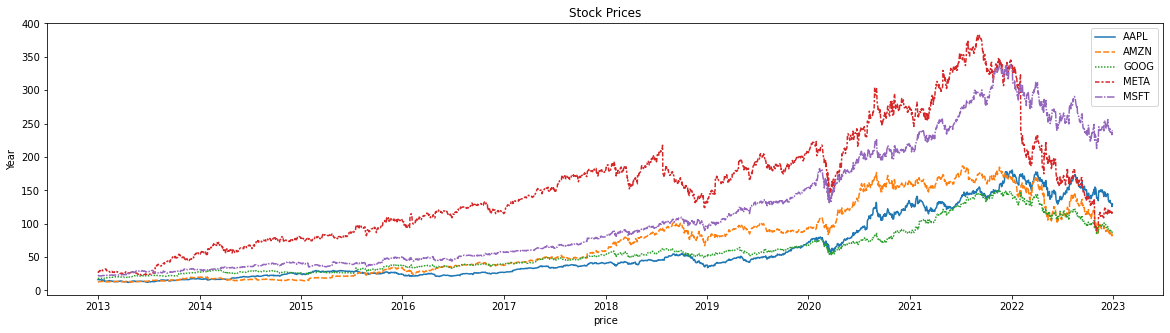

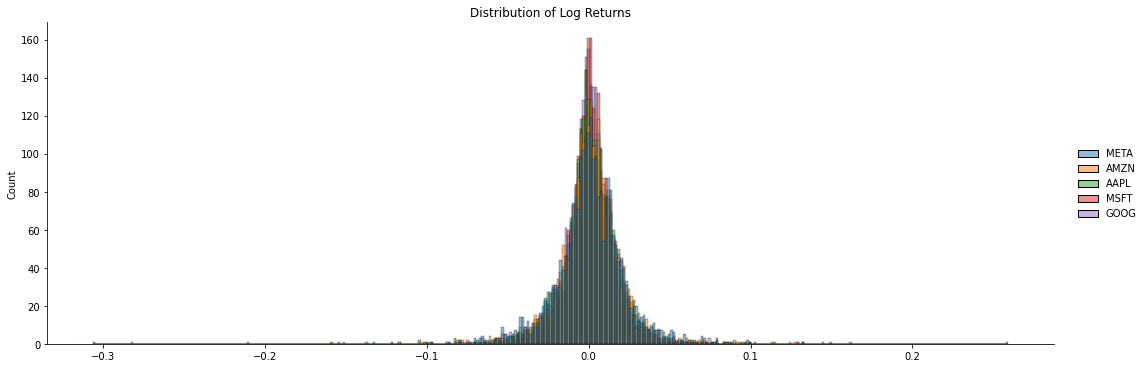

In [47]:
# sets the size of the lineplot
plt.figure(figsize=(20,5));plt.xlabel('price');plt.ylabel('Year');plt.title('Stock Prices')
sns.lineplot(data = prices_df)

# sets the aspect ratio of the distribution plot 
sns.displot(data = log_returns_df,height = 5, aspect = 3, kde=False); plt.title('Distribution of Log Returns')
plt.show()

<blockquote> <strong><em>The log returns largely follow a normal distribution. This has been reported in many finance studies so the results are not surprising.</em></strong>   </blockquote>

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Observing the correlation of returns between Tech stocks

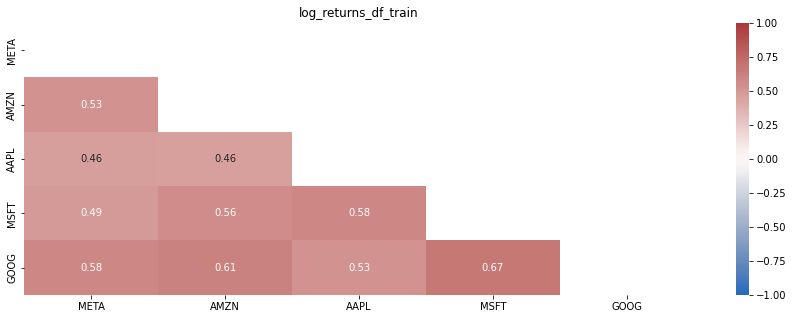

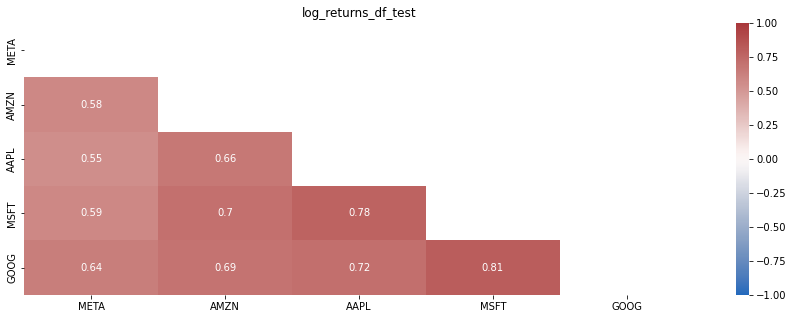

In [48]:
correlation_matrix(dataset = log_returns_df_train)
correlation_matrix(dataset = log_returns_df_test)

\begin{equation*}
  r =
  \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
\end{equation*}
- Stocks returns are positively correlated with each other over a 10-year period, highest being GOOG and MSFT (0.7). 
- When creating diversified portfolios, it is best to avoid those with high correlation to one another. So it is best to avoid putting more than one of these stocks into your portfolio.

- Time-series Xt and Yt are cointegrated if their linear combination aXt+bYt is stationary, where X and Y are the stock prices respectively. 

- Correlation $\neq $ Cointegration. A way to differentiate correlation and cointegration is this example.
1. IF the two stock prices are cointegrated, then we predict that the spread between the two prices will not deviate significantly on average. <br> 
BUT the returns may be different for both stocks. In theory, the two prices will converge to the same value. <br> Lastly, Cointegration describes a long-term relationship between prices.

2. For correlation, the two prices may deviate significantly EVEN IF the correlation is high.<br> Lastly, Correlation describes a short-term relationship between log returns.

*Refer to <a href=https://hudsonthames.org/an-introduction-to-cointegration>Cointegration examples</a> for examples on how highly cointegrated stocks can have negative correlation in returns and highly correlated prices are not cointegrated.

<blockquote><b> The correlation of log returns for the test set is higher than the training set. The correlation of returns for all these stocks are high but for this example, we will still use them.  </b> </blockquote>

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Testing Cointegration and Autocorrelation using Linear regression models 

#### Performing Augmented Dickey Fuller test

In [49]:
# perform ADF test on each pair of stocks
symbols = ['META', 'AMZN','AAPL', 'MSFT', 'GOOG']

# Number of permutations of unique pairs is 5C2 = 10
list = []
i = 0 
j = 1
while i < 4:
    while j < 5: 
        # print(i,j) sanity check 
        list.append([symbols[i],symbols[j]])
        j+=1
    i+=1 
    j=i+1

META  and  AMZN  are NOT cointegrated. p - value is: 0.7876277245961432
META  and  AAPL  are NOT cointegrated. p - value is: 0.9928539900959762
META  and  MSFT  are NOT cointegrated. p - value is: 0.7728323231213501
META  and  GOOG  are cointegrated. p - value is: 0.05029581602701069
                                 OLS Regression Results                                
Dep. Variable:                   META   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                          1.289e+05
Date:                Mon, 19 Jun 2023   Prob (F-statistic):                        0.00
Time:                        00:00:05   Log-Likelihood:                         -8710.3
No. Observations:                2016   AIC:                                  1.742e+04
Df Residuals:                    2015   BIC:                                  1.743e+04
Df Model:  

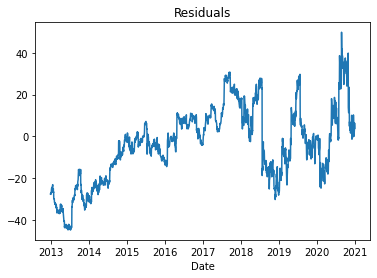

In [50]:
adfpair_test(dataset = prices_df_train, list = list)

<blockquote><strong>The R-Squared value is 0.985.</strong></blockquote>

#### Performing Engle Granger Test

In [51]:
EG_test(dataset = prices_df_train)

META  and  AMZN  are NOT cointegrated. p - value is: 0.27119563874548447 t-statistics is: -2.5179840570303034
META  and  AAPL  are NOT cointegrated. p - value is: 0.8608637644389545 t-statistics is: -1.188588493863532
META  and  MSFT  are NOT cointegrated. p - value is: 0.46195943060142586 t-statistics is: -2.1275837896178937
META  and  GOOG  are cointegrated. p - value is: 0.046145865999544664 t-statistics is: -3.367036684107777
AMZN  and  AAPL  are NOT cointegrated. p - value is: 0.8332043237255216 t-statistics is: -1.2884143607580567
AMZN  and  MSFT  are NOT cointegrated. p - value is: 0.41670733863380516 t-statistics is: -2.2148734835914157
AMZN  and  GOOG  are cointegrated. p - value is: 0.018339796708047716 t-statistics is: -3.6997346810857215
AAPL  and  MSFT  are NOT cointegrated. p - value is: 0.9603037028844953 t-statistics is: -0.5534206978876351
AAPL  and  GOOG  are NOT cointegrated. p - value is: 0.9481453981565462 t-statistics is: -0.6858348124874308
MSFT  and  GOOG  are N

<blockquote>Since only (META,GOOG) and (AMZN,GOOG) are cointegrated as confirmed by either tests (Augmented Dickey-Fuller Test/ Engel Granger Test), we shall focus on these two pairs of stocks. <br>
We will perform autocorrelation tests for their returns to see if they can be forecasted by past returns. </blockquote>

In [52]:
autocorr('META','GOOG',dataset = log_returns_df_train)

                            OLS Regression Results                            
Dep. Variable:               dataset1   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     1023.
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          8.09e-182
Time:                        00:00:07   Log-Likelihood:                 5288.5
No. Observations:                2015   AIC:                        -1.057e+04
Df Residuals:                    2013   BIC:                        -1.056e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.373      0.1

In [53]:
autocorr('AMZN','GOOG',dataset =log_returns_df_train)

                            OLS Regression Results                            
Dep. Variable:               dataset1   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     1191.
Date:                Mon, 19 Jun 2023   Prob (F-statistic):          2.04e-205
Time:                        00:00:07   Log-Likelihood:                 5568.0
No. Observations:                2015   AIC:                        -1.113e+04
Df Residuals:                    2013   BIC:                        -1.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0007      0.000      2.030      0.0


**From the results, the p-value for all the durbin watson test is $\approx 2 $**
<blockquote> So there is NO auto-correlation for the regression models. That means that the future returns cannot be forecasted by the past returns. <br>
IF there is auto-correlation, that means that the stock returns could exhibit momentum. </blockquote>


<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Adding columns to prices_df_test

In [54]:
# Copying columns over for convenience so prices_df contains all the necessary columns

# For the training set
addcolumn(prices_df_train,'META_returns',log_returns_df_train,'META')
addcolumn(prices_df_train,'GOOG_returns',log_returns_df_train,'GOOG')
addcolumn(prices_df_train,'AMZN_returns',log_returns_df_train,'AMZN')

# For the test set (Out-of-Sample)
addcolumn(prices_df_test,'META_returns',log_returns_df_test,'META')
addcolumn(prices_df_test,'GOOG_returns',log_returns_df_test,'GOOG')
addcolumn(prices_df_test,'AMZN_returns',log_returns_df_test,'AMZN')

# print(prices_df_test)

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Fitting regression line for stock prices.

Results of Dickey-Fuller Test:
Test Statistic                -6.985258e+00
p-value                        7.999349e-10
#Lags Used                     2.300000e+01
Number of Observations Used    1.943000e+03
Critical Value (1%)           -3.433720e+00
Critical Value (5%)           -2.863029e+00
Critical Value (10%)          -2.567563e+00
dtype: float64


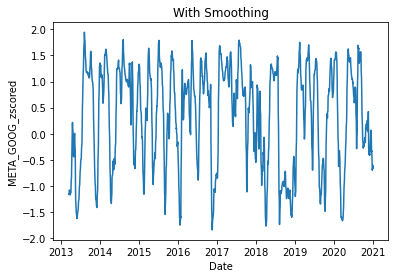

In [55]:
# The coefficient is used for the price spread when smoothing
rsquared = beta('META','GOOG',prices_df_train)

# Creates price spread of the two stocks
# The Smoothed zscore is able to remove short-term fluctuations and outliers associated with the current trend. 
smoothing('META', 'GOOG', coeff = rsquared, dataset = prices_df_train, smooth = True)

# dropna is required otherwise there will be this error (MissingDataError: exog contains inf or nans)
adfsingle_test(prices_df_train['META_GOOG_zscored'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -5.704403e+00
p-value                        7.546347e-07
#Lags Used                     2.200000e+01
Number of Observations Used    1.944000e+03
Critical Value (1%)           -3.433718e+00
Critical Value (5%)           -2.863028e+00
Critical Value (10%)          -2.567562e+00
dtype: float64


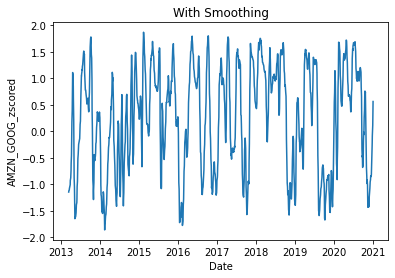

In [56]:
# The coefficient is used for the price spread when smoothing
rsquared2 = beta('AMZN','GOOG',prices_df_train)

# Creates price spread of the two stocks
# The Smoothed zscore is able to remove short-term fluctuations and outliers associated with the current trend. 
smoothing('AMZN', 'GOOG', coeff = rsquared2, dataset = prices_df_train, smooth = True)

# dropna is required otherwise there will be this error (MissingDataError: exog contains inf or nans)
adfsingle_test(prices_df_train['AMZN_GOOG_zscored'].dropna())

<blockquote> We can see that when we smooth the spread, the p-value for both tests are < 0.05. <br> Thus, The zscored spread times-series is stationary for the training datasets. (constant mean and variance across time) </blockquote>

#### Now doing it on the test set using the training set rsquared values

Results of Dickey-Fuller Test:
Test Statistic                  -3.123370
p-value                          0.024871
#Lags Used                      11.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


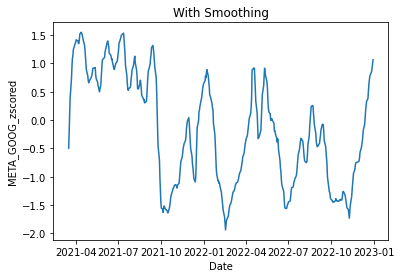

In [57]:
smoothing('META', 'GOOG', coeff = rsquared, dataset = prices_df_test, smooth = True)
adfsingle_test(prices_df_test['META_GOOG_zscored'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -4.572730
p-value                          0.000145
#Lags Used                      11.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


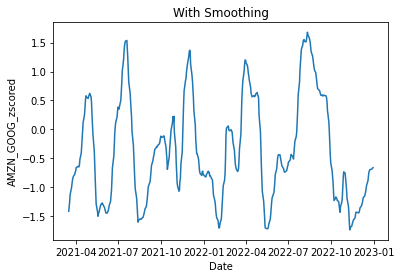

In [58]:
smoothing('AMZN', 'GOOG', coeff = rsquared2, dataset = prices_df_test, smooth = True)
adfsingle_test(prices_df_test['AMZN_GOOG_zscored'].dropna())

<blockquote> We can see that when we smooth the spread, the p-value for both tests are < 0.05. Thus, The zscored spread times-series is stationary for the test datasets. <br>(constant mean and variance across time) </blockquote>

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Finalising Trading Strategy

We will trade when the z-scored spread between the two stocks exceed the spread in the function. <br> When reverse is False ,we will long the first stock and short the second stock. When reverse is True, we will do the opposite. <br> The fees are added after trading for simplicity purposes.<br> <br>
The green graph shows when there is trading activity (when value is 1) or you can think of it graphically as a green column with height 1 whenever there are trades that day. <br>
We will assume holding costs of stocks to be 0.

PnL is : 63.34822266711511 %


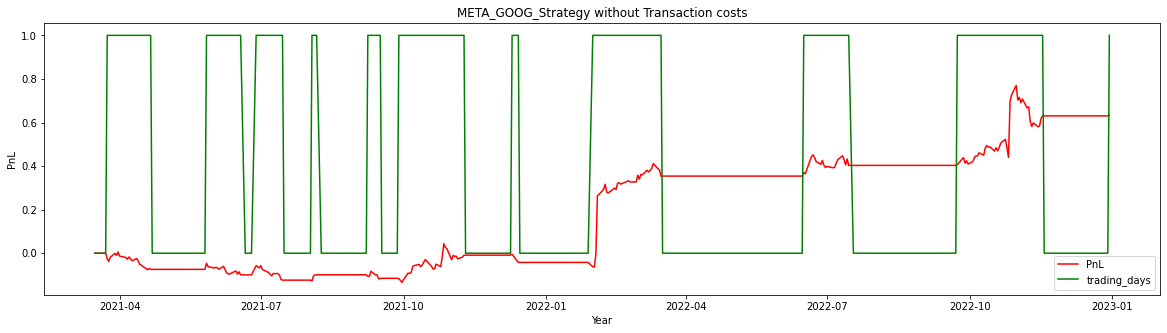

In [59]:
strategy('META','GOOG', reverse = False,  dataset = prices_df_test, fees = 0, spread = 1)

PnL is : 4.063294576897025 %


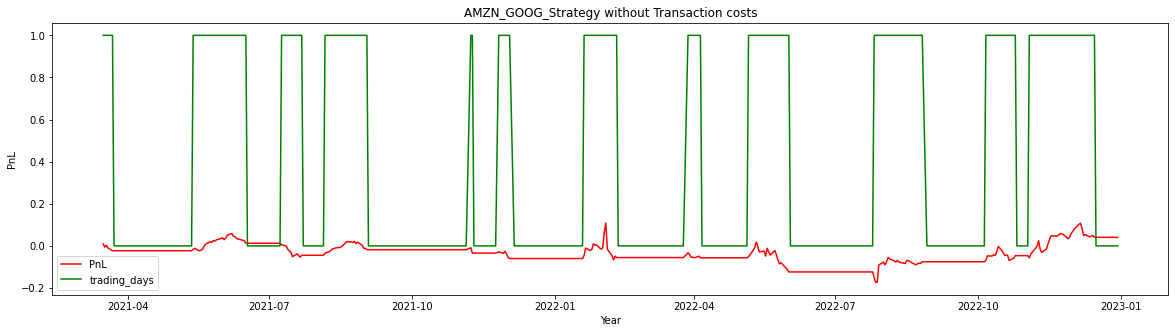

In [60]:
strategy('AMZN', 'GOOG', reverse = False, dataset = prices_df_test, fees = 0, spread = 1)

<blockquote> Only the results for META_GOOG look promising as the Profit and Loss graph is about 63% at the end of 2 years. <br>  But, we did not factor in possible transaction costs (market spreads, commissions, etc.). <br> We will now assume a fixed transaction cost of 0.1% (fees value) which will be deducted from our returns that trading day.</blockquote>

PnL is : 17.948222667115065 %


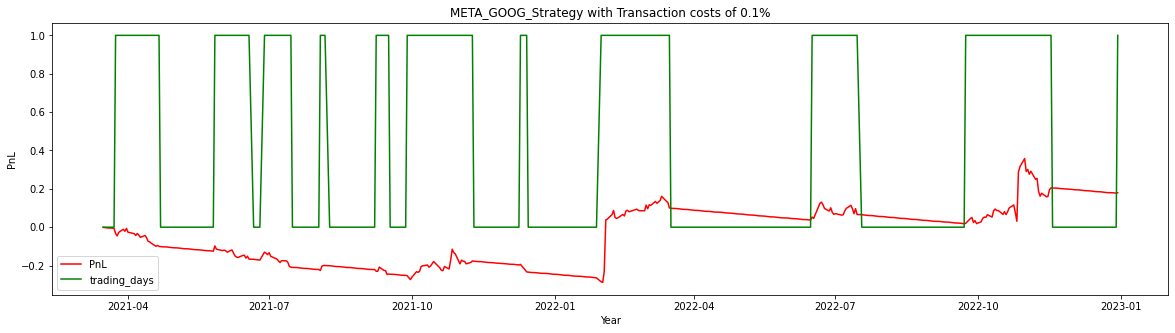

In [61]:
strategy('META', 'GOOG', reverse = False, dataset = prices_df_test, fees = 0.1, spread = 1)

<blockquote> After assuming fixed transaction costs when we trade that day, the PnL graph is now worse. The Profit is approximately 18% for META_GOOG over 2 years  </blockquote>

PnL is : -41.33670542310301 %


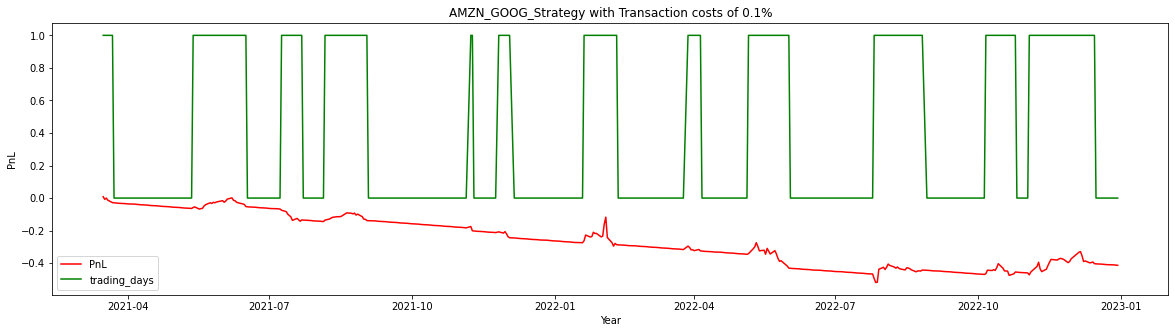

In [62]:
strategy('AMZN', 'GOOG', reverse = False, dataset = prices_df_test, fees = 0.1, spread = 1)

<blockquote> After assuming fixed transaction costs when we trade that day, the PnL graph is now worse. The loss is approximately 41% for AMZN_GOOG over 2 years. </blockquote>

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Two things to take note of:
1. The PnL graph shows a negative trend. Maybe we can reverse the trading rules and see if it our PnL graph can be positive.
2. We did not implement any additional rules for trading which may limit transaction costs. <br> Example rules could include monitoring volume and market sentiment regarding the stocks. <br> If this are positive for the respective stocks, then we are more likely to trade the stock and vice versa.

PnL is : -63.34822266711511 %
PnL is : -108.74822266711467 %


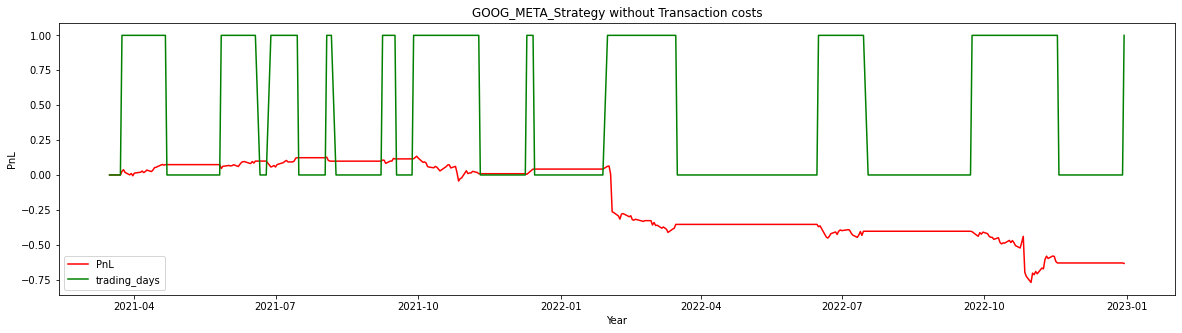

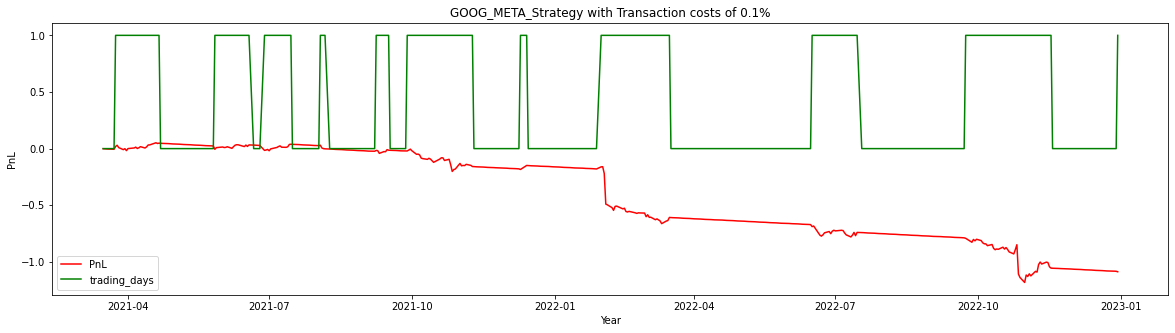

In [63]:
strategy('META', 'GOOG', reverse = True, dataset = prices_df_test, fees = 0, spread = 1)
strategy('META', 'GOOG', reverse = True, dataset = prices_df_test, fees = 0.1, spread = 1)

<blockquote> The loss is now approximately 63% and 108% over 2 years respectively. Now trying GOOG_AMZN strategy </blockquote>

PnL is : -4.063294576897025 %
PnL is : -49.46329457689706 %


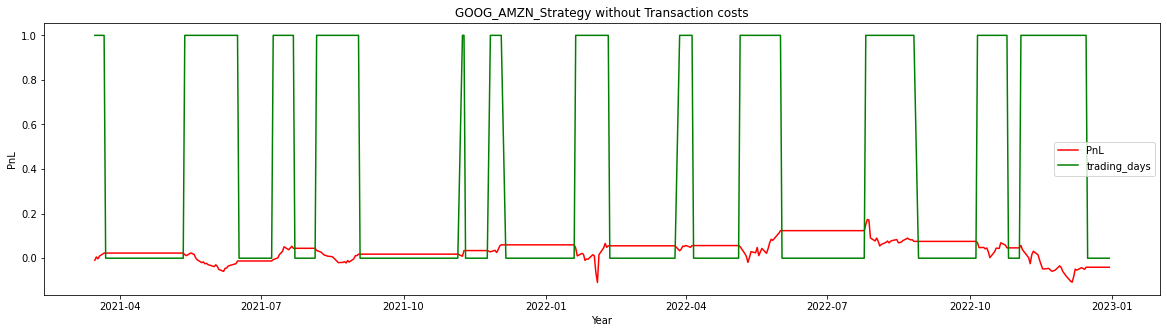

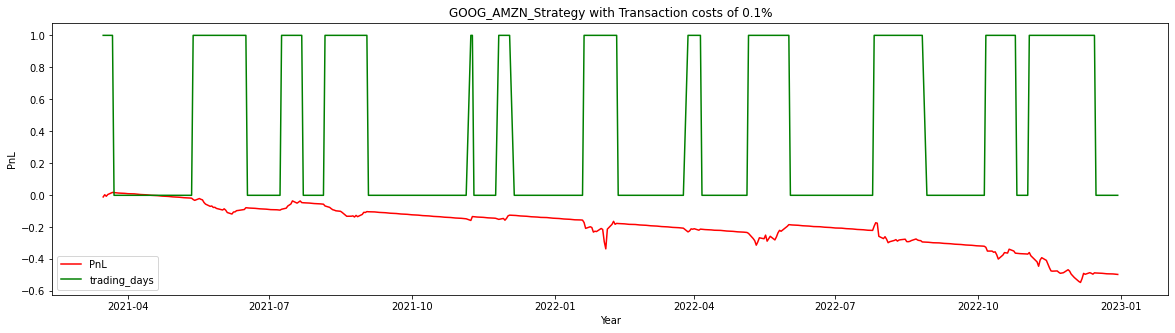

In [64]:
strategy('AMZN', 'GOOG', reverse = True, dataset = prices_df_test, fees = 0, spread = 1)
strategy('AMZN', 'GOOG', reverse = True, dataset = prices_df_test, fees = 0.1, spread = 1)

<blockquote>GOOG_META strategy performed much worse while GOOG_AMZN performed relatively the same. </blockquote>

- After accounting for transaction costs, Either normal or reversed strategy does not work as well when the transaction costs eat into whatever Profits we could muster from this strategy.  
- <b> This is also a takeaway that just because the stock prices are cointegrated does not mean that riskless profits can be made.<br> We have to also account for transaction costs and turnover rate, and make sure that the returns before the transaction costs are significant enough to warrant trading.<b>
- Lastly, the transaction costs used are already quite low, thus real PnL may be worse.

In [65]:
with pd.ExcelWriter(r"C:\Users\Cornelius\Downloads\export_dataframe.xlsx",engine='xlsxwriter') as writer:
    prices_df_test.to_excel(writer, sheet_name="Specific") 

In [66]:
# Track program execution 
print(f'Time: {time.time() - start}')

Time: 10.30406665802002


<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">

### Appendix

| Index | Documentation  |
|--------------|------|
|   Pandas     | https://pandas.pydata.org/pandas-docs/stable/reference/|
|   Numpy      | https://numpy.org/doc/1.24/reference/index.html|
|   Statsmodels| https://www.statsmodels.org/stable/api.html|
|   Plotly     | https://plotly.com/python/time-series/ |
|   Latex      | https://www.overleaf.com/learn/latex/Subscripts_and_superscripts |

Some ideas to further expand the strategy:
- Employ group_backfill to replace nan-values 
- Add a technical indicator as an additional condition for entry
- Additional rules for selecting stock pair. 
- Using the johansen cointegration test for multiple time-series (allows up to 12)
- Using cointegration on a basket of stocks (sectors or industries)

- add sharpe ratio and other financial metrics
\begin{equation*}
  Sharpe Ratio = 
  \frac{ R_{p} - R_{f}}
  {\sigma_{p}}
\end{equation*}

$$\begin{align}
R_{p}: Expected\ Return\ of\ portfolio\newline
R_{f}: Risk-free\ rate\ of\ return \newline
\sigma_{p}: Standard\ Deviation\ of\ Returns\newline
\end{align}$$

References:
<nav>
<a href=https://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root>Time Series Stationarity and unit roots</a> |
<a href=https://hudsonthames.org/an-introduction-to-cointegration>Cointegration examples</a> |
<a href=https://quant.stackexchange.com/questions/1027/how-are-correlation-and-cointegration-related>Correlation vs Cointegration </a> |
<a href=https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing-Part-II>Mean Reversion </a> |
<a href=https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio>Johansen Test </a> |
<a href=https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python>Moving Averages </a> |<br>
<a href=https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd>Jupyter Markdown guide </a> | 
<a href=https://betterdatascience.com/style-pandas-dataframes>Pandas Styling </a> | <br>
<a href=https://epchan.blogspot.com/2007/04/anonymous-reader-l-posted-some.html>epchan quant blog</a> |
<a href=https://letianzj.github.io/archives>Letian quant blog </a> |
</nav> 

<hr style="height:10px;border:none;background-color:rgb(255, 255, 0);">